# GLRT LinUCB

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit, hls_rank_combined
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls, make_hls_rank
from lrcb.representations.finite_representations import is_cmb, is_hls, spans, hls_lambda, derank_cmb, LinearRepresentation
from lrcb.representations.finite_representations import reduce_dim, fuse_columns
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
from lrcb.algos.maximin_oful import maximin_oful
from lrcb.algos.glrt_oful import glrt_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu
from jupyterthemes import jtplot
#jtplot.style()
plt.rcParams['figure.figsize'] = [12, 9]

## Common settings

In [2]:
nc = 20
na = 4
dim = 5
noise = 0.1
seeds = range(5)

Generate original HLS representation

In [3]:
#r0 = make_random_rep(nc, na, dim, normalize=True)
r0 = LinearRepresentation(np.load('../logs/basic_features.npy'), np.load('../logs/basic_param.npy'))
assert is_hls(r0)

OFUL settings

In [4]:
iterations = 10000
reg = 1
delta = 0.01
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

## Basic Problem

5 equivalent representations of dimension 5, of increasing hls rank, only one is HLS (the last)

In [5]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

for r in reps:
    print('%d/%d' % (hls_rank(r), rank(r)))

1/5
2/5
3/5
4/5
5/5


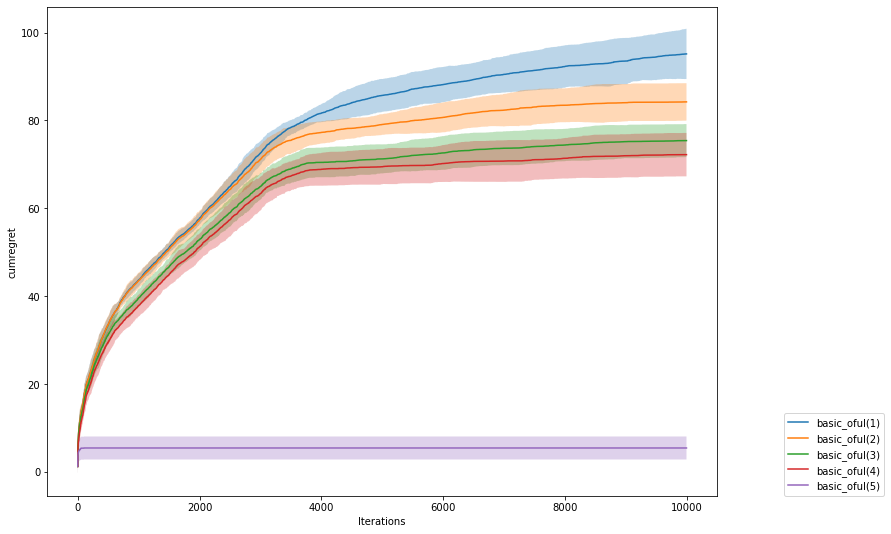

In [6]:
nu.compare('../logs', ['basic_oful(%d)' % hls_rank(r) for r in reps], 'cumregret', seeds)

In [7]:
oracle = 'basic_oful(5)'
dummy = 'basic_oful(4)'

## Comparison of maximin and glrt

In [8]:
problem.reset()
delta2 = delta / len(reps)

In [9]:
for seed in seeds:
    glrt_oful(problem, iterations, reg, noise, delta2, param_bound, 
                robin=True,
                seed=seed, verbose=False, logname='basic_glrt')

**glrt**

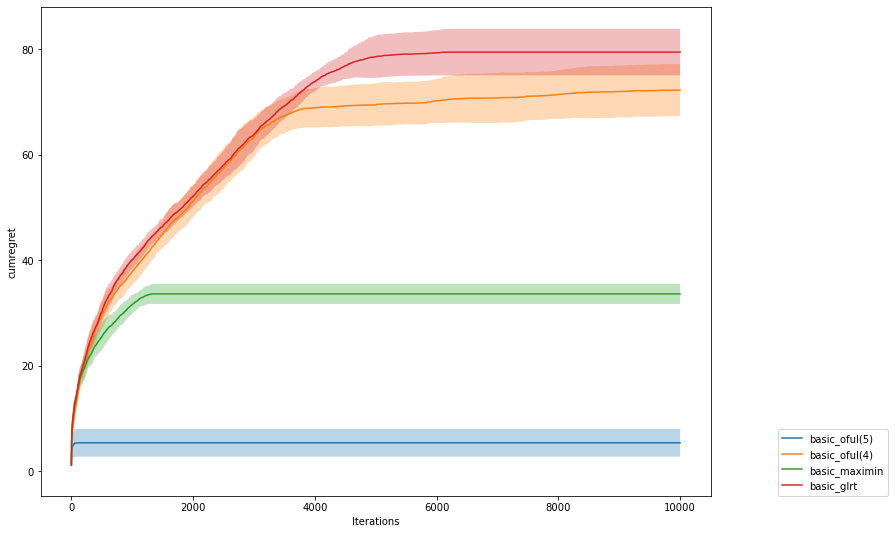

In [10]:
nu.compare('../logs', [oracle, dummy, 'basic_maximin', 'basic_glrt'], 
           'cumregret', seeds)

This is ratio - beta (the test triggers when score > 0, the score is not computed afterwards)

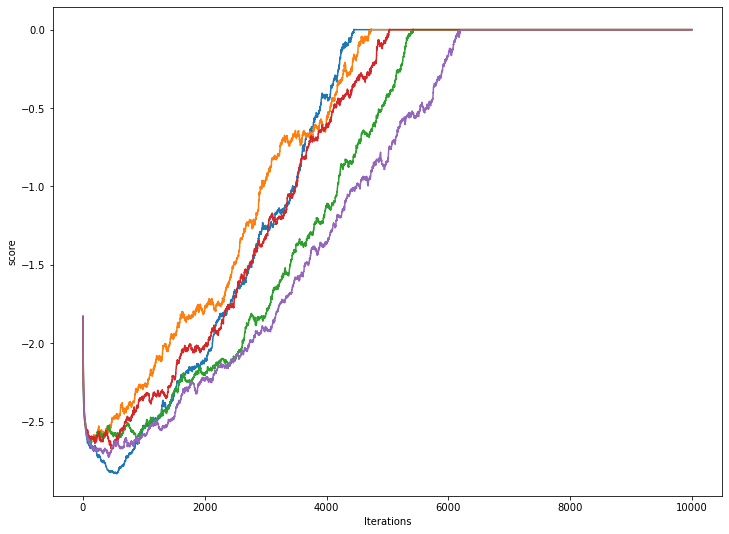

In [11]:
nu.plot_all('../logs', 'basic_glrt', 'score', seeds)

Round robin vs uniform (u)

In [12]:
for seed in seeds:
    glrt_oful(problem, iterations, reg, noise, delta2, param_bound, 
                robin=False,
                seed=seed, verbose=False, logname='basic_glrt(u)')

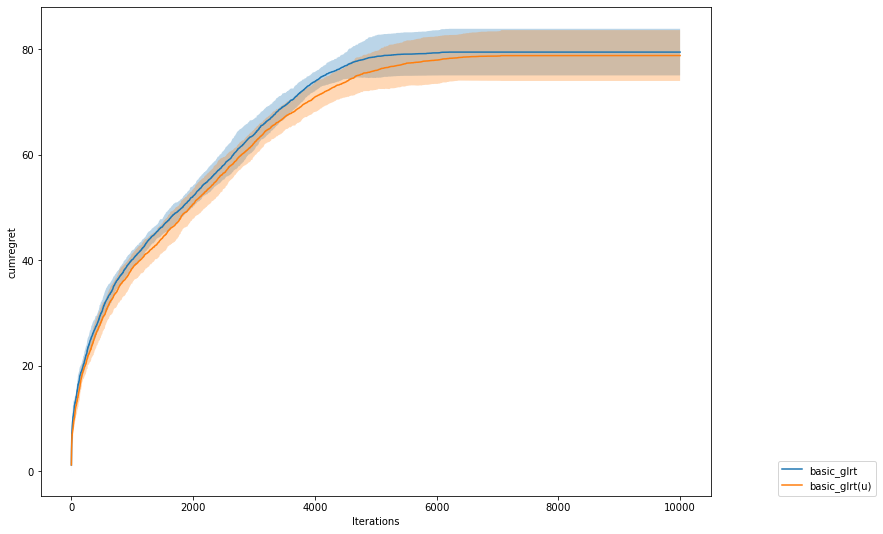

In [13]:
nu.compare('../logs', ['basic_glrt', 'basic_glrt(u)'], 
           'cumregret', seeds)

What happens without HLS?

In [14]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
problem = FiniteMultiBandit(nc, na, reps)

In [15]:
for seed in seeds:
    glrt_oful(problem, iterations, reg, noise, delta2, param_bound, 
                robin=True,
                seed=seed, verbose=False, logname='nohls_glrt')

In [16]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound, 
                seed=seed, verbose=False, logname='nohls_maximin')

GLRT seems to mimic the worst, MAXIMIN the best

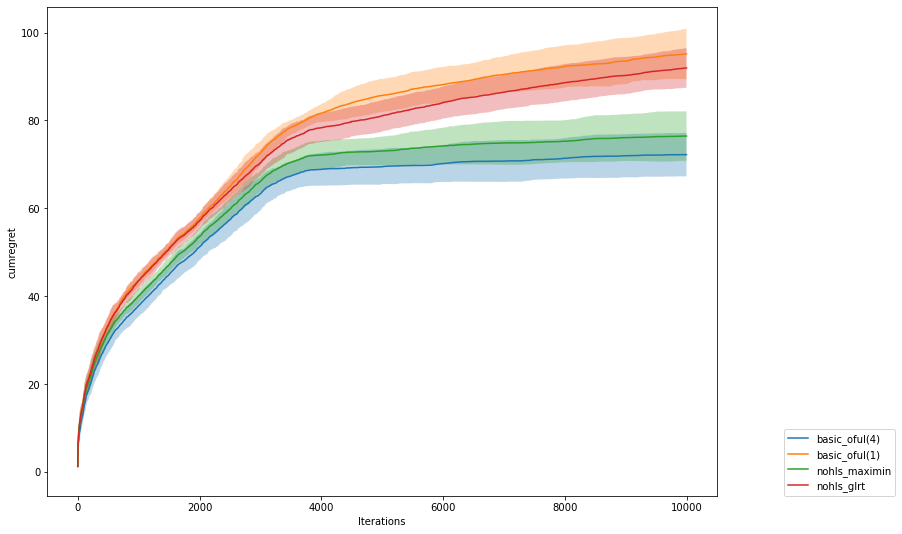

In [17]:
nu.compare('../logs', ['basic_oful(4)', 'basic_oful(1)', 'nohls_maximin', 'nohls_glrt'], 
           'cumregret', seeds)

The test never triggers

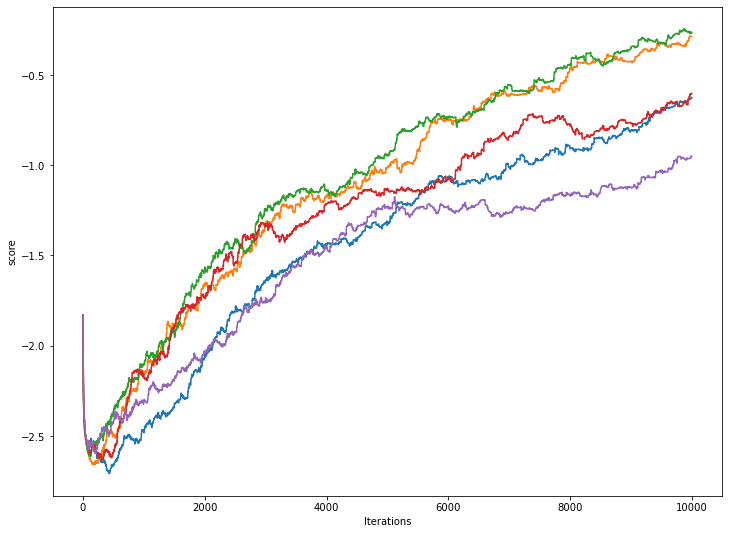

In [18]:
nu.plot_all('../logs', 'nohls_glrt', 'score', seeds)

## The "weird" problem

In [19]:
y = r0._rewards()
reps = [make_hls_rank(y, dim=dim, rank=i, transform=True, normalize=True) for i in range(1, dim+1)]

for i, r in enumerate(reps):
    assert np.allclose(r._rewards(), y)  #All representations are equivalent
    assert hls_rank(r) == i+1 #But with different HLS ranks
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.opt_feat_bound(), r.opt_feat_bound(reduce=np.min)))
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/5 (CMB) 3.373791 0.025049
2/5 (CMB) 3.490786 0.025049
3/5 (CMB) 3.587163 0.025049
4/5 (CMB) 3.587163 0.025049
5/5 (CMB) 4.107827 0.025049


In [20]:
for i in range(len(reps)):
    problem.select_rep(i)
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, 
                           logname='weird_oful(%d)' % hls_rank(reps[i]))

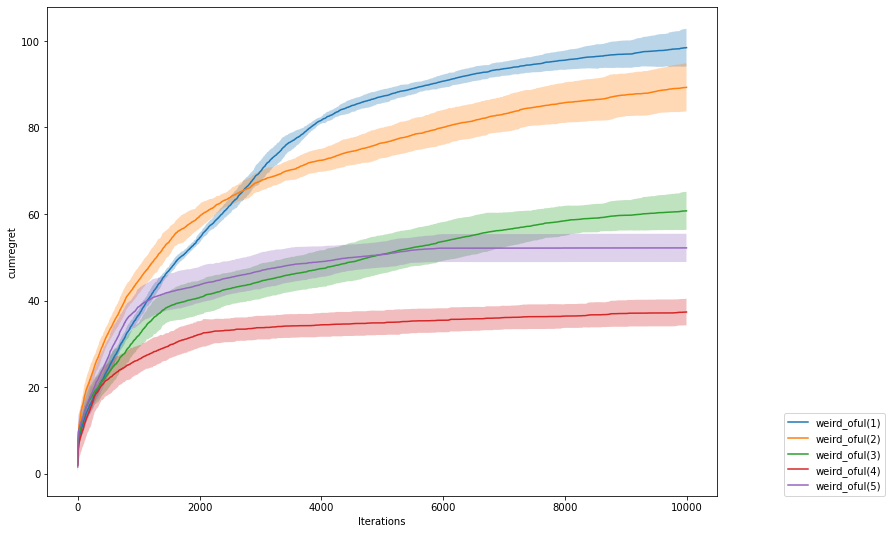

In [21]:
nu.compare('../logs', ['weird_oful(%d)' % hls_rank(r) for r in reps], 'cumregret', seeds)

In [22]:
problem.reset()
delta2 = delta / len(reps)

In [23]:
for seed in seeds:
    glrt_oful(problem, iterations, reg, noise, delta2, param_bound, 
                robin=True,
                seed=seed, verbose=False, logname='weird_glrt')

In [24]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound, 
                seed=seed, verbose=False, logname='weird_maximin')

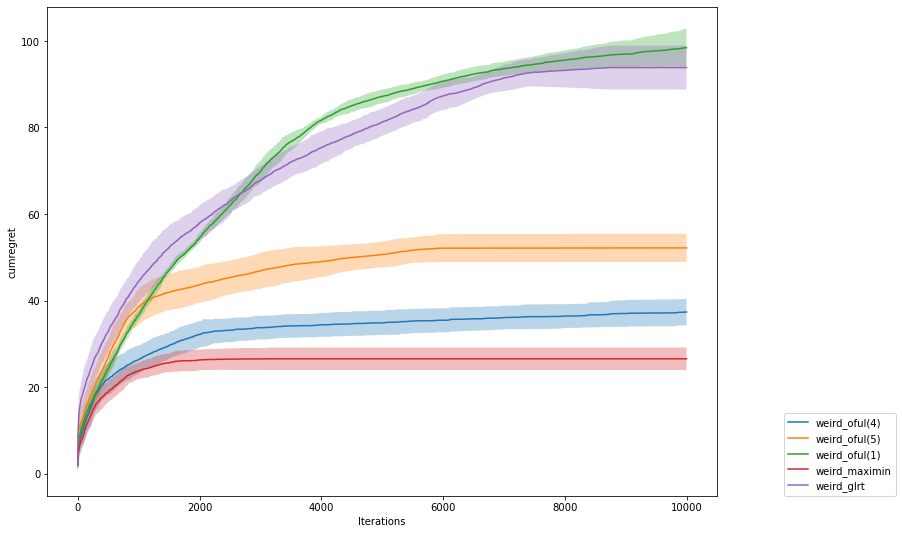

In [25]:
nu.compare('../logs', ['weird_oful(4)', 'weird_oful(5)', 'weird_oful(1)', 'weird_maximin', 'weird_glrt'], 
           'cumregret', seeds)

Same without HLS

In [26]:
y = r0._rewards()
reps = [make_hls_rank(y, dim=dim, rank=i, transform=True, normalize=True) for i in range(1, dim)]

for i, r in enumerate(reps):
    assert np.allclose(r._rewards(), y)  #All representations are equivalent
    assert hls_rank(r) == i+1 #But with different HLS ranks
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.opt_feat_bound(), r.opt_feat_bound(reduce=np.min)))
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/5 (CMB) 3.373791 0.025049
2/5 (CMB) 3.490786 0.025049
3/5 (CMB) 3.587163 0.025049
4/5 (CMB) 3.587163 0.025049


In [27]:
problem.reset()
delta2 = delta / len(reps)

In [28]:
for seed in seeds:
    glrt_oful(problem, iterations, reg, noise, delta2, param_bound, 
                robin=True,
                seed=seed, verbose=False, logname='weirdnohls_glrt')

In [29]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound, 
                seed=seed, verbose=False, logname='weirdnohls_maximin')

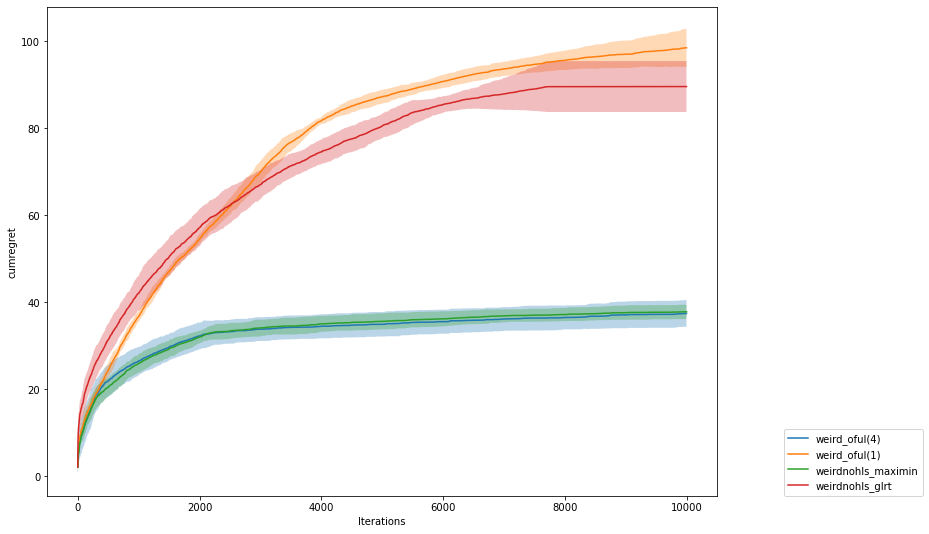

In [30]:
nu.compare('../logs', ['weird_oful(4)', 'weird_oful(1)', 'weirdnohls_maximin', 'weirdnohls_glrt'], 
           'cumregret', seeds)

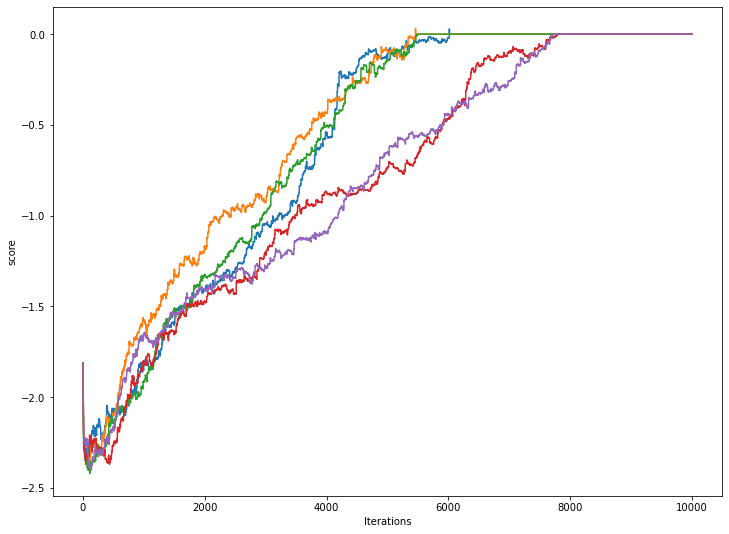

In [31]:
nu.plot_all('../logs', 'weirdnohls_glrt', 'score', seeds)